# Book Genre Prediction
Welcome, this my final project for the Introduction to Deep Learning which will be based on NLP and try to replicate some of the models to evaluate which one does a better job and if we could improve on them to get a higher accuracy score.

## The Challenge
With this [dataset](https://www.kaggle.com/datasets/athu1105/book-genre-prediction?select=data.csv) provided by the Kaggle uer Atharva Inamdar the objective is to predict the genre of a book with its sinopsis as the main feature.

This is something more interesting to me since this is not only a **True** or **False** problem but we have more categories here which is relevant to NLP problems where we need to get a deeper understanding of the inputs.

I'll be using text vectorization and try to use two different models and compare them.

# The Data
## Exploratory Data Analyis
I'll start with exploring the provided data and see the dimension and features of the provided data.

In [29]:
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import losses

In [30]:
# Importing the Data
data = pd.read_csv('../input/book-genre-prediction/data.csv', usecols=['title', 'genre', 'summary'], dtype='str')
data.head()

,title,genre,summary
0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...
1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ..."
2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...
3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...
4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...


In [31]:
# Brief overview of the data how it looks
data.info

<bound method DataFrame.info of                                   title    genre  \
0                     Drowned Wednesday  fantasy   
1                         The Lost Hero  fantasy   
2             The Eyes of the Overworld  fantasy   
3                       Magic's Promise  fantasy   
4                        Taran Wanderer  fantasy   
...                                 ...      ...   
4652                            Hounded  fantasy   
4653  Charlie and the Chocolate Factory  fantasy   
4654                         Red Rising  fantasy   
4655                          Frostbite  fantasy   
4656                           Radiance  fantasy   

                                                summary  
0      Drowned Wednesday is the first Trustee among ...  
1      As the book opens, Jason awakens on a school ...  
2      Cugel is easily persuaded by the merchant Fia...  
3      The book opens with Herald-Mage Vanyel return...  
4      Taran and Gurgi have returned to Caer Dallben.

In [32]:
# Example summary of a book
example = data.sample(1, random_state=42, axis=0)
print(list(example['summary']))

[" Thomas Jerome Newton is a humanoid alien who comes to Earth seeking to construct a spaceship to ferry others from his home planet, Anthea, to Earth. Anthea is experiencing a terrible drought after many nuclear wars, and the population has dwindled to less than 300. They have hundreds of superior starships, but for not being used for over 500 years, they are unusable because of little to no fuel. They have no water, loads of food that is slowly dwindling, and feeble solar power. Like all Antheans, he is super-intelligent, but he has been selected to complete this mission for his strength, due to the harsh climate and gravity of Earth compared to the cold, small Anthea. Getting to Earth via a lifeboat, Newton first lands in the state of Kentucky but quickly becomes familiarized with the environment and aspires to become an entrepreneur. Newton uses advanced technology from his home planet to patent many inventions on Earth, and rises as the head of a technology-based conglomerate to i

In [33]:
# List of genres to be predicted
genre_list = data['genre'].unique()
print('Number of genres:', len(genre_list))
print(genre_list)

Number of genres: 10
['fantasy' 'science' 'crime' 'history' 'horror' 'thriller' 'psychology'
 'romance' 'sports' 'travel']


In [34]:
# Missing Data
data.isna().sum()

title      0
genre      0
summary    0
dtype: int64

<AxesSubplot:>

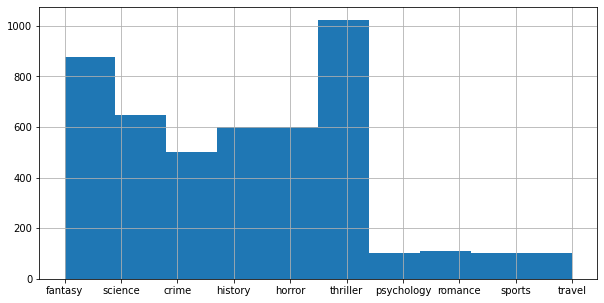

In [35]:
# Distribution of target lables
data['genre'].hist(figsize=(10,5))

<AxesSubplot:title={'center':'Summary word count'}>

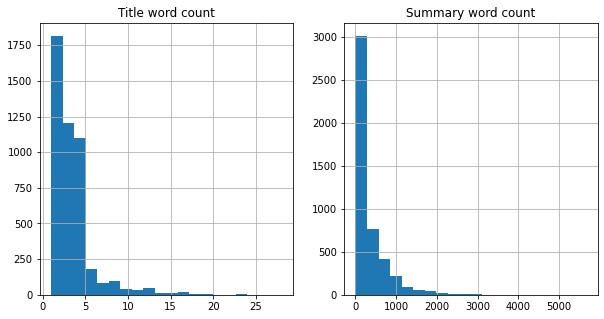

In [36]:
plt.subplots(1,2, figsize=(10,5))

plt.subplot(121)
plt.title('Title word count')
data['title'].str.split().map(len).hist(bins=20)

plt.subplot(122)
plt.title('Summary word count')
data['summary'].str.split().map(len).hist(bins=20)

In [37]:
data['title'].str.split().map(len).describe()

count    4657.000000
mean        3.477775
std         2.580572
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        28.000000
Name: title, dtype: float64

In [38]:
data['summary'].str.split().map(len).describe()

count    4657.000000
mean      359.148594
std       437.584315
min         1.000000
25%       118.000000
50%       193.000000
75%       436.000000
max      5663.000000
Name: summary, dtype: float64

### EDA Results
* We have a total of 4,657 records belonging to 10 different genres.
    * There are no missing records.
    * We see with describe the distribution of words which is important to define hyperparameters if I elect to use some text length parameters.
* The genres are not evenly distributed, we might need to have more examples from `'psychology', 'romance', 'sports', 'travel'` in order to get a better model to predict this kind of cases.
* Title and Summary word counts have some limits which will be useful for the text vectorization, for example a summary with more than 2,000 words might be an outlier we do not want to consider to avoid overfitting the model.
* **Text Cleanup**
    * A lot of the text contains periods comas and capital letters, I'll be handling this with the **Tensorflow** `TextVectorization` module in order for it to follow a standard set of rules to do this preprocessing for me. You can read more about it [**here**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) to see some of the arguments that are available within the library.

## Data Preprocessing
I'll begin with the data preprocessing by spliting into train/test sets to then obtain the validation dataset from the test set.

### Datasets

In [39]:
train, test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True, stratify=data['genre'].values)

In [40]:
validation = test.sample(frac=0.5, random_state=42)
test.drop(validation.index, inplace=True)

print(f'Number of rows in training set: {len(train)}')
print(f'Number of rows in validation set: {len(validation)}')
print(f'Number of rows in test set: {len(test)}')

Number of rows in training set: 3725
Number of rows in validation set: 466
Number of rows in test set: 466


### Support Functions and Variables
Here will be the section where I gather the functions I'll refer to this part whenever the function is used. Additionally here are some parameters used to measure and evaluate the models like the batch size and number of epochs to train.

In [41]:
# Support Functions & Setup
# Training Plots
def plot_result(history,item):
    """
    Generate plot from history dependant on the item to evaluate.
    history: fitted model
    item: model metric like accuracy
    """
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

# Encoder Translation
def invert_multi_hot(encoded_labels):
    """
    Reverse a single multi-hot encoded label to a tuple of vocab terms.
    encoded_labels: encoded labels array
    returns the 'genre(s)'
    """
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

# Dataset Creation
def make_dataset(dataframe, is_train=True):
    """
    From a specified dataframe extract the columns of interest ['genre', 'interest'].
    'genre' column is passed through the encoder layer
    If the dataset is for training it shuffles the dataset.
    returns a tensorflow dataset
    """
    labels = tf.ragged.constant(dataframe['genre'].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe['summary'].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

# Setup
batch_size = 64 # Batch hyperparameter
auto = tf.data.AUTOTUNE
epochs = 20

### Text Datasets, Vectorization & Encoding
For this section I'll start to one hot encode the `genre` column we can do that with tensorflow with `tf.keras.layers.StringLookup` with the `'one_hot'` parameter. This layer will create an array and one hot encode the genres. 

**Support Function:** With this layer we also create the `invert_multi_hot` function which is basically turning from the one hot encoded tensor to the labels.

In [42]:
terms = tf.constant(train['genre'].values)
lookup = tf.keras.layers.StringLookup(output_mode='one_hot')
lookup.adapt(terms)
vocab = lookup.get_vocabulary()

print(f'Vocabulary: {vocab}')

Vocabulary: ['[UNK]', 'thriller', 'fantasy', 'science', 'horror', 'history', 'crime', 'romance', 'travel', 'sports', 'psychology']


In [43]:
sample_label = train['genre'].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: fantasy
Label-binarized representation: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


**Support Function:** Here we created the `make_dataset` function which will be applied to each of our dataframe subsets in order to transform them into tensors to then pass them through more layers which will vectorize the input texts.

In [44]:
train_ds = make_dataset(train, is_train=True)
validation_ds = make_dataset(validation, is_train=False)
test_ds = make_dataset(test, is_train=False)

#### Vectorizing Layer
Here I'm leveraging a vectorizing layer from a previous project for another [competition](https://www.kaggle.com/competitions/nlp-getting-started). This layer will help us transform the paragraphs from the summaries into vectors that will be manageable for our neural network. To work with this layer first we need to see the vocabulary of our training data, after we get that we create the vectorization layer which additionally will support on the data cleaning with standarization args.

In [45]:
vocabulary = set()
train['summary'].str.lower().str.split().apply(vocabulary.update)
max_vocabulary = len(vocabulary)

vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=max_vocabulary,
    ngrams = 2
)

print(f'Number of words in vocabulary: {max_vocabulary}')

Number of words in vocabulary: 102208


In [46]:
with tf.device('/CPU:0'):
    vectorize_layer.adapt(train_ds.map(lambda text, label: text))

# Models
## Model 1
For the first achitecture I'll be based on a simple example from the tensorflow library looking into RNN. You can read about it [here](https://www.tensorflow.org/text/tutorials/text_classification_rnn#stack_two_or_more_lstm_layers) with this model we create a model which does the following:

1. Convert text to a sequence of token indices.
2. Store one vector per word with embedding to then called to conver teh sequences of word of indices to sequences of vectors.
3. The RNN with the Bidirectional layer which propagates the inputs forwards and backwards.
4. The final Dense layers to finish the processing the information to then convert into a single vector which is our final output.

In [47]:
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()),output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11)
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 64)          6541312   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 11)                715       
Total params: 6,616,331
Trainable params: 6,616,331
Non-trainable params: 0
_________________________________________________________________


From the tensorflow documentation I'll try to use the [tf.keras.losses.CategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) function, from the description we see it is a good loss function to use in this case "*Use this crossentropy loss function when there are two or more label classes. We expect labels to be provided in a one_hot representation.*" For the optimizer I'll keep the Adam we've been using so far and again from the documentation our metric will be [tf.keras.metrics.categorical_accuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/categorical_accuracy)

In [48]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['categorical_accuracy']
)

Epoch 1/20
59/59 [==============================] - 27s 349ms/step - loss: 2.3783 - categorical_accuracy: 0.1989 - val_loss: 2.3413 - val_categorical_accuracy: 0.2339
Epoch 2/20
59/59 [==============================] - 18s 312ms/step - loss: 2.1730 - categorical_accuracy: 0.2207 - val_loss: 2.0535 - val_categorical_accuracy: 0.2361
Epoch 3/20
59/59 [==============================] - 19s 316ms/step - loss: 2.0356 - categorical_accuracy: 0.2201 - val_loss: 2.0384 - val_categorical_accuracy: 0.2361
Epoch 4/20
59/59 [==============================] - 19s 316ms/step - loss: 2.0168 - categorical_accuracy: 0.2481 - val_loss: 2.0068 - val_categorical_accuracy: 0.2382
Epoch 5/20
59/59 [==============================] - 18s 304ms/step - loss: 1.9551 - categorical_accuracy: 0.2655 - val_loss: 1.9359 - val_categorical_accuracy: 0.2983
Epoch 6/20
59/59 [==============================] - 19s 316ms/step - loss: 1.9257 - categorical_accuracy: 0.2773 - val_loss: 1.9207 - val_categorical_accuracy: 0.324

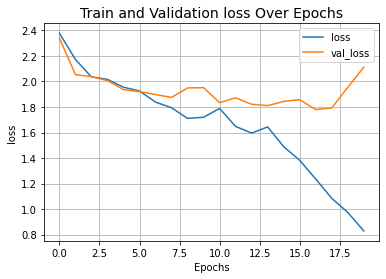

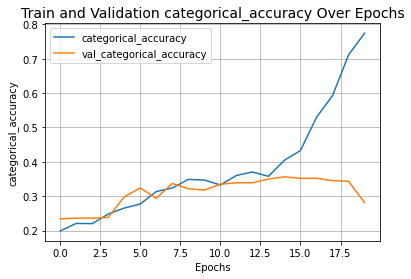

In [49]:
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=validation_ds
)

plot_result(history, "loss")
plot_result(history, "categorical_accuracy")

## Model 2
Building on the first model, the batch size I used within the layers, in this one I'll try to increase the number of batches to increase the number of training parameters and see how that impacts on the results if adding an additional layer might be helpful to allow the model to adjust better.

To keep things consistent I'll be compiling with the same loss, optimizer and metrics.

In [50]:
model2 = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()),output_dim=128, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11),
])

model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 128)         13082624  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 11)                715       
Total params: 13,206,923
Trainable params: 13,206,923
Non-trainable params: 0
__________________________________________

In [51]:
model2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['categorical_accuracy']
)

Epoch 1/20
59/59 [==============================] - 28s 359ms/step - loss: 2.3761 - categorical_accuracy: 0.2140 - val_loss: 2.3316 - val_categorical_accuracy: 0.2361
Epoch 2/20
59/59 [==============================] - 19s 326ms/step - loss: 2.1787 - categorical_accuracy: 0.2196 - val_loss: 2.0590 - val_categorical_accuracy: 0.2361
Epoch 3/20
59/59 [==============================] - 19s 329ms/step - loss: 2.0293 - categorical_accuracy: 0.2191 - val_loss: 2.0368 - val_categorical_accuracy: 0.2361
Epoch 4/20
59/59 [==============================] - 19s 326ms/step - loss: 2.0074 - categorical_accuracy: 0.2336 - val_loss: 2.0021 - val_categorical_accuracy: 0.2361
Epoch 5/20
59/59 [==============================] - 20s 334ms/step - loss: 1.9534 - categorical_accuracy: 0.2510 - val_loss: 1.9274 - val_categorical_accuracy: 0.3112
Epoch 6/20
59/59 [==============================] - 19s 322ms/step - loss: 1.8549 - categorical_accuracy: 0.3028 - val_loss: 2.0004 - val_categorical_accuracy: 0.279

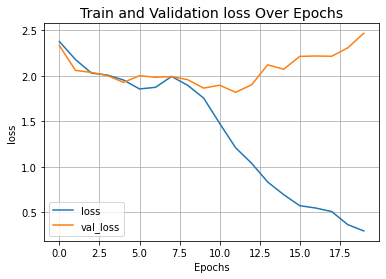

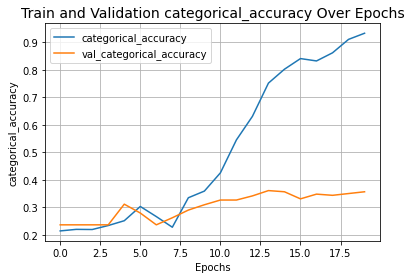

In [52]:
history2 = model2.fit(
    train_ds,
    epochs=epochs,
    validation_data=validation_ds,
)

plot_result(history2, "loss")
plot_result(history2, "categorical_accuracy")

### Extra Model
For this one I'l lbe trying to implement the [Large-scale multi-label text classification](https://keras.io/examples/nlp/multi_label_classification/) model which suggest differente preprocessing hyperparamters specifically in the text vectorization.

The changes are basically that we're keeping the rough text but now we're expressing the output differently and using the ngrams args. In terms of the output it suggets the TF-IDF algorithm which is completely different to what we used on our previous layer, the ngrams parameter will take into consideration pairs of words which together might have some impact within the summaries giving them much more relevance.

Following the tutorial suggestion we need to re-do some text preprocessing on our datasets for them to be vectorized correctly.

In [53]:
text_vectorizer = layers.TextVectorization(
    max_tokens=max_vocabulary,
    ngrams=2,
    output_mode="tf_idf"
)

with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_ds.map(lambda text, label: text))

train_ds = train_ds.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
validation_ds = validation_ds.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
test_ds = test_ds.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)

#### Model
This model is super simple a fully connected layers with ReLU, and I'll keep the compilation parameters to see how this fares against the others.

In [54]:
def make_model():
    shallow_mlp_model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(512, activation="relu"),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]
    )
    return shallow_mlp_model

Epoch 1/20
59/59 [==============================] - 2s 32ms/step - loss: 2.6095 - categorical_accuracy: 0.5106 - val_loss: 1.6720 - val_categorical_accuracy: 0.6094
Epoch 2/20
59/59 [==============================] - 2s 28ms/step - loss: 0.2490 - categorical_accuracy: 0.9638 - val_loss: 1.6878 - val_categorical_accuracy: 0.6738
Epoch 3/20
59/59 [==============================] - 2s 29ms/step - loss: 0.1550 - categorical_accuracy: 0.9702 - val_loss: 1.6854 - val_categorical_accuracy: 0.6588
Epoch 4/20
59/59 [==============================] - 2s 27ms/step - loss: 0.1098 - categorical_accuracy: 0.9715 - val_loss: 1.6546 - val_categorical_accuracy: 0.6738
Epoch 5/20
59/59 [==============================] - 2s 27ms/step - loss: 0.0823 - categorical_accuracy: 0.9726 - val_loss: 1.7447 - val_categorical_accuracy: 0.6695
Epoch 6/20
59/59 [==============================] - 2s 31ms/step - loss: 0.0827 - categorical_accuracy: 0.9715 - val_loss: 1.5504 - val_categorical_accuracy: 0.7082
Epoch 7/20

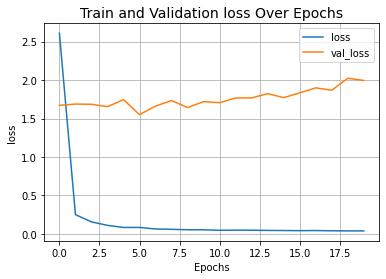

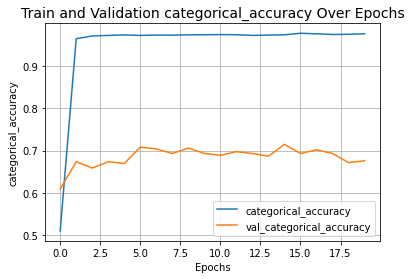

In [55]:
shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history3 = shallow_mlp_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs
)

plot_result(history3, "loss")
plot_result(history3, "categorical_accuracy")

### All Together
Something the tutorial shows is a best practice to packing the models. In this case we are doing the `model_for_inference` which is a good way to keep the consistency of the model after training it to use. I'm choosing to keep the last interation since it was the one that achieved the highest validation accuracy.

See for yourself and try to read the summary created from the test dataset and see if it classified it correctly.

In [56]:
# Create a model for inference.
model_for_inference = tf.keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:2]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Summary: {text}")
    print(f"Genre: {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:1]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

Summary: b' Equality 7-2521, writing in a tunnel under the earth, later revealed to be an ancient subway tunnel, explains his background, the society around him, and his emigration. His exclusive use of plural pronouns ("we", "our", "they") to refer to himself and others tells a tale of complete socialization and governmental control. The idea of the World Council was to eliminate all individualist ideas. It was so stressed, that people were burned at the stake for saying an Unspeakable Word ("I", "Me", "Myself", and "Ego"). He recounts his early life. He was raised, like all children in the world of Anthem, away from his parents in the Home of the Infants, then transferred to the Home of the Students, where he began his schooling. Later, he realized that he was born with a "curse": He is eager to think and question, and unwilling to give up himself for others, which violates the principles upon which Anthems society is founded. He excelled in math and science, and dreamed of becoming 

# Analysis
## The Models
* With the first two models we get similar results despite adding more parameters to be trained.
* The third model despite being simple performed better but there was one big difference compared to the first two, the preprocessing.
    * Text preprocessing is something crucial when feeding information into a model, the hyperparameters within the preprocessing might be as important as the model itself since feeding good quality data is important to ensure adequate training.
* Training information can quickly overfit, from the graphs we see how the accuracy of the training data quickly went over 90% categorical accuracy but our validation set did not improve at all, this could be due to the amount of data available or the simplicity of the models which might tend to quickly overfit.

## The Data
* I need to esnure the EDA is done more thoroughly since I saw at the very end it was possible to have summaries on different languages, this could alter out text vectorization, models, preprocessing since these have a weight within the model that is not zero.
* The volume in the end might not have been enough to perform this NLP analysis, the tutorial I refered to and the tensorflow documentation uses data which was about 4-6 times my data.

## Results
* The first two model had low accuracy scores on the validation data despite achieveing a decent training accuracy.
* The last simple connected layers performed better on all of the data.

# Conclusion
Building the models from scratch were much harder than I thought. I did not achieve a good result and I invested a lot of time working on the model outputs rather than the preprocessing which is a key step on the project that I need to focus more. Using Keras tutorials helped me undestand a lot more in terms of text handling and how it could be used to do not only binary classification but multi class classficiation.

Learning about inferencing is something important because it enables oneself to share and avoid issues with modifying other pars of the code which one could leverage for other projects and keep track of the changes we do to our main branch.

NLP is a topic I'd like to explore more in the future since the number of models one can build are infinite and even the existing ones are so flexible to the point that they might be the key to the success of our work as Data Scientists.

# Works Cited
* Paul, Sayak. “Large-scale multi-label text classification.” Keras, 25 September 2020, https://keras.io/examples/nlp/multi_label_classification/. Accessed 11 October 2022.
* “Text classification with an RNN.” TensorFlow, 5 April 2022, https://www.tensorflow.org/text/tutorials/text_classification_rnn#stack_two_or_more_lstm_layers. Accessed 11 October 2022.

